In [36]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats

def find_global_average_TLS(calendar_TLS_maps):
    lats = np.arange(-88.75, 88.76, 2.5)
    weights = np.swapaxes(np.broadcast_to(np.cos(np.deg2rad(lats)), (144,72)), 0,1)
    TLS_calendar = []
    for year_of_data in calendar_TLS_maps:
        TLS_by_year = []
        for month_of_data in year_of_data:
            nan_binary_map = np.divide(month_of_data, month_of_data)
            weighted_TLS_map = np.multiply(weights, month_of_data)
            weighted_binary_map = np.multiply(weights, nan_binary_map)
            average_TLS = np.nansum(weighted_TLS_map)/np.nansum(weighted_binary_map)
            #average_TLS = np.nanmean(weighted_TLS_map)
            TLS_by_year.append(average_TLS)
        TLS_calendar.append(TLS_by_year)
    return(np.array(TLS_calendar))

# load anomaly maps from RO (and get anomaly calendar) and STAR datasets
ROTLSMaps = np.load('/home/bdc2/aodhan/ROM_SAF/TLS_MonthlyMeanMaps/ROTLSMonthlyMeanMaps_2001_2022.npy')
ROTLSclimatology = np.nanmean(ROTLSMaps[7:17], axis=0)
ROTLSMaps = ROTLSMaps - ROTLSclimatology
STARTLS = np.load('/home/bdc2/aodhan/ROM_SAF/TLS_MonthlyMeanMaps/STARTLSMonthlyMeanAnomalyMaps_2002_2022.npy')

ROMaskedCalendar = []
STARMaskedCalendar = []
for yr in range(2002, 2022):
    yr_idx_RO = yr - 2001
    yr_idx_STAR = yr - 2002
    ROMaskedMonthMaps = []
    STARMaskedMonthMaps = []
    for m_idx in range(0,12):
        RO_map = ROTLSMaps[yr_idx_RO, m_idx]
        STAR_map = STARTLS[yr_idx_STAR, m_idx]
        bool_nan_RO_map = np.abs(np.isnan(RO_map) - 1)
        bool_nan_STAR_map = np.abs(np.isnan(STAR_map) - 1)
        both_have_data_map = np.multiply(bool_nan_RO_map, bool_nan_STAR_map)
        bool_mask = np.abs(both_have_data_map - 1)
        
        RO_map_masked = np.ma.masked_array(RO_map, mask=bool_mask,fill_value=np.nan)
        RO_map_masked = RO_map_masked.filled()
        STAR_map_masked = np.ma.masked_array(STAR_map, mask=bool_mask,fill_value=np.nan)
        STAR_map_masked = STAR_map_masked.filled()
        
        ROMaskedMonthMaps.append(RO_map_masked)
        STARMaskedMonthMaps.append(STAR_map_masked)
    ROMaskedCalendar.append(ROMaskedMonthMaps)
    STARMaskedCalendar.append(STARMaskedMonthMaps)
    
ROGlobalMeanCalendar = find_global_average_TLS(ROMaskedCalendar)[7:17]
STARGlobalMeanCalendar = find_global_average_TLS(STARMaskedCalendar)[7:17]
ROGlobalMeanTS = np.reshape(ROGlobalMeanCalendar, (np.shape(ROGlobalMeanCalendar)[0]*np.shape(ROGlobalMeanCalendar)[1]))
STARGlobalMeanTS = np.reshape(STARGlobalMeanCalendar, (np.shape(STARGlobalMeanCalendar)[0]*np.shape(STARGlobalMeanCalendar)[1]))

difference = ROGlobalMeanTS - STARGlobalMeanTS

/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


In [37]:
def trend_finder(time_series):
    months = np.linspace(0,len(time_series), len(time_series))
    months_nonnan = months[~np.isnan(time_series)]
    time_series_nonan = time_series[~np.isnan(time_series)]
    slope, intercept = stats.linregress(months_nonnan, time_series_nonan)[:2]
    best_fit = intercept + slope*months_nonnan
    decadal_trend = slope*12*10
    error = time_series_nonan - best_fit
    N = len(time_series_nonan)
    r_autocorrelation = stats.pearsonr(time_series_nonan[:-1], time_series_nonan[1:])[0]
    Neff = N * ((1 - r_autocorrelation)/(1 + r_autocorrelation))
    standard_error_squared = (1/(Neff -2))*np.sum(error**2)
    standard_error_x2 = standard_error_squared*2
    
    return(str(decadal_trend)[:6], str(standard_error_x2)[:6])
    

RO_slope, RO_CI = trend_finder(ROGlobalMeanTS)
STAR_slope, STAR_CI = trend_finder(STARGlobalMeanTS)
diff_slope, diff_CI = trend_finder(difference)

Text(0.5, 0, 'Years')

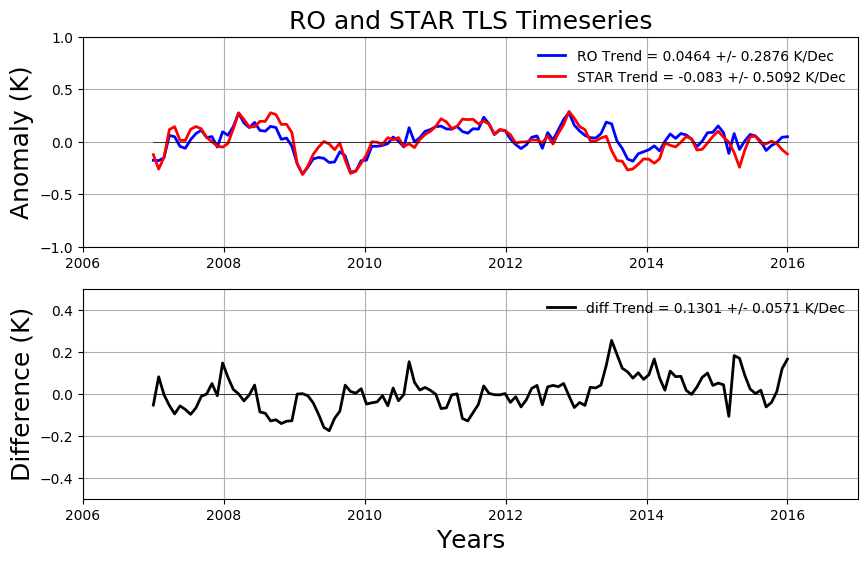

In [38]:
fig, axs = plt.subplots(2,1,figsize=(10,6))

axs[0].plot(np.linspace(2007, 2016, 120), ROGlobalMeanTS, color='blue', linewidth=2, label=('RO Trend = ' + RO_slope + ' +/- ' + RO_CI + ' K/Dec' ))
axs[0].plot(np.linspace(2007, 2016, 120), STARGlobalMeanTS, color='red', linewidth=2, label=('STAR Trend = ' + STAR_slope + ' +/- ' + STAR_CI + ' K/Dec' ))
axs[0].plot(np.linspace(2007, 2016, 120), np.zeros(len(ROGlobalMeanTS)), color='black', linewidth=0.5)
axs[0].set_ylim(-1,1)
axs[0].set_xlim(2006,2017)
axs[0].legend(frameon=False)
axs[0].grid()

axs[1].plot(np.linspace(2007, 2016, 120), difference, color='black', linewidth=2, label=('diff Trend = ' + diff_slope + ' +/- ' + diff_CI + ' K/Dec' ))
axs[1].legend(frameon=False)
axs[1].set_ylim(-.5,.5)
axs[1].plot(np.linspace(2007, 2016, 120), np.zeros(len(ROGlobalMeanTS)), color='black', linewidth=0.5)
axs[1].set_xlim(2006,2017)
axs[1].grid()

axs[0].set_title('RO and STAR TLS Timeseries', fontsize=18)
axs[0].set_ylabel('Anomaly (K)', fontsize=18)
axs[1].set_ylabel('Difference (K)', fontsize=18)
axs[1].set_xlabel('Years', fontsize=18)

ValueError: x and y must have same first dimension, but have shapes (240,) and (120,)

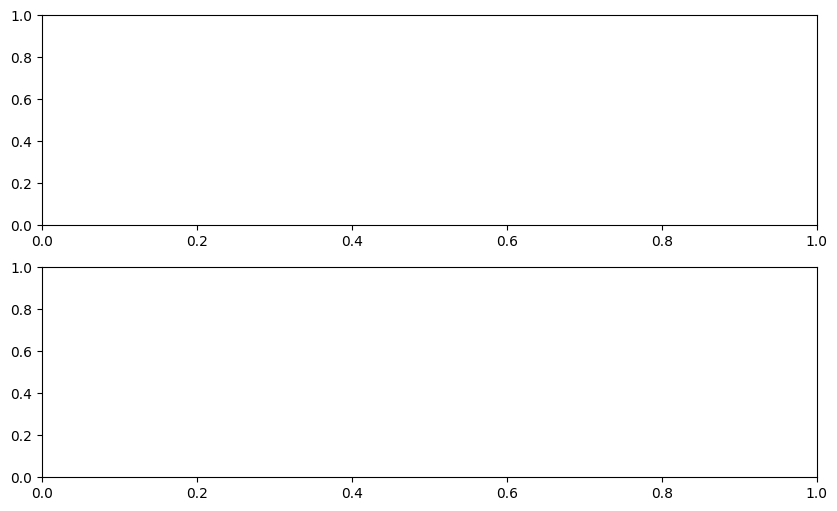

In [32]:
fig, axs = plt.subplots(2,1,figsize=(10,6))

axs[0].plot(np.linspace(2002, 2022, 240), ROGlobalMeanTS, color='blue', linewidth=2, label=('RO Trend = ' + RO_slope + ' +/- ' + RO_CI + ' K/Dec' ))
axs[0].plot(np.linspace(2002, 2022, 240), STARGlobalMeanTS, color='red', linewidth=2, label=('STAR Trend = ' + STAR_slope + ' +/- ' + STAR_CI + ' K/Dec' ))
axs[0].plot(np.linspace(2002, 2022, 240), np.zeros(len(ROGlobalMeanTS)), color='black', linewidth=0.5)
axs[0].set_ylim(-1,1)
axs[0].set_xlim(2002,2022)
axs[0].legend(frameon=False)
axs[0].grid()

axs[1].plot(np.linspace(2002, 2022, 240), difference, color='black', linewidth=2, label=('diff Trend = ' + diff_slope + ' +/- ' + diff_CI + ' K/Dec' ))
axs[1].legend(frameon=False)
axs[1].set_ylim(-.5,.5)
axs[1].plot(np.linspace(2002, 2022, 240), np.zeros(len(ROGlobalMeanTS)), color='black', linewidth=0.5)
axs[1].set_xlim(2002,2022)
axs[1].grid()

axs[0].set_title('RO and STAR TLS Timeseries', fontsize=18)
axs[0].set_ylabel('Anomaly (K)', fontsize=18)
axs[1].set_ylabel('Difference (K)', fontsize=18)
axs[1].set_xlabel('Years', fontsize=18)

Text(0.5, 0, 'Years')

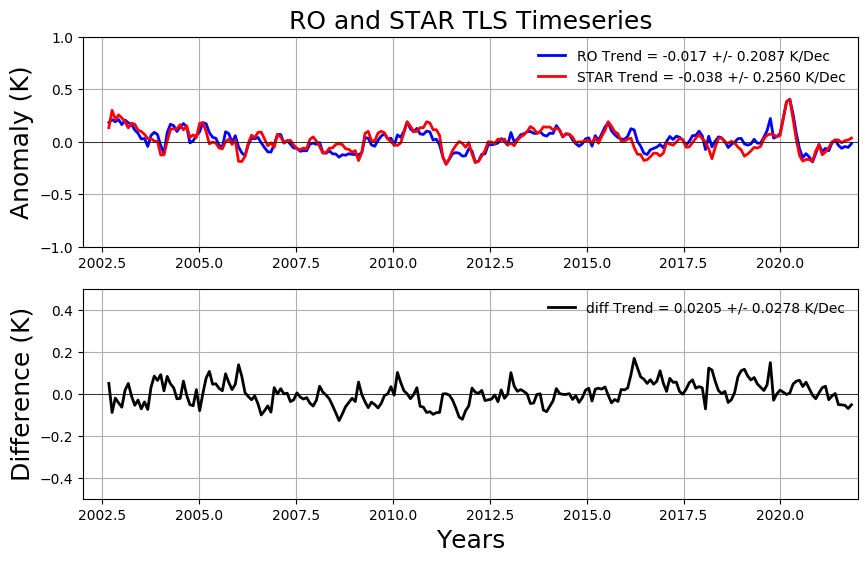

In [20]:
fig, axs = plt.subplots(2,1,figsize=(10,6))

axs[0].plot(np.linspace(2002, 2022, 240), ROGlobalMeanTS, color='blue', linewidth=2, label=('RO Trend = ' + RO_slope + ' +/- ' + RO_CI + ' K/Dec' ))
axs[0].plot(np.linspace(2002, 2022, 240), STARGlobalMeanTS, color='red', linewidth=2, label=('STAR Trend = ' + STAR_slope + ' +/- ' + STAR_CI + ' K/Dec' ))
axs[0].plot(np.linspace(2002, 2022, 240), np.zeros(len(ROGlobalMeanTS)), color='black', linewidth=0.5)
axs[0].set_ylim(-1,1)
axs[0].set_xlim(2002,2022)
axs[0].legend(frameon=False)
axs[0].grid()

axs[1].plot(np.linspace(2002, 2022, 240), difference, color='black', linewidth=2, label=('diff Trend = ' + diff_slope + ' +/- ' + diff_CI + ' K/Dec' ))
axs[1].legend(frameon=False)
axs[1].set_ylim(-.5,.5)
axs[1].plot(np.linspace(2002, 2022, 240), np.zeros(len(ROGlobalMeanTS)), color='black', linewidth=0.5)
axs[1].set_xlim(2002,2022)
axs[1].grid()

axs[0].set_title('RO and STAR TLS Timeseries', fontsize=18)
axs[0].set_ylabel('Anomaly (K)', fontsize=18)
axs[1].set_ylabel('Difference (K)', fontsize=18)
axs[1].set_xlabel('Years', fontsize=18)